# Importing the necessary libraries

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import base64
from PIL import Image
import io
import math 
from math import sqrt
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import functools
import librosa
import PIL.Image

%matplotlib inline

global embed
embed = hub.KerasLayer(os.getcwd())
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In the second model we will be using the VGG19 model trained on imagenet. Neural Style transfer is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network. Here are the certain libraries we will be using in this script.


# Reading Image and converting it to Tensor

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_path = '/content/content.jpg'
style_path = '/content/style.jpg'

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

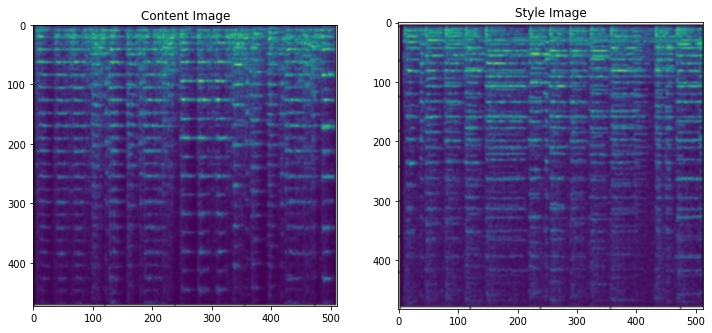

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

Here we are reading the image and converting it into tensors.  The loaded image is limited at a maximum dimension of 512 pixels. These are our content and style images.

# Model Build

Onto the main part now, the model building. We used the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, we are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, we matched the corresponding style and content target representations at these intermediate layers. Let’s load the VGG19 model without the classification head and list down the layer names.


In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 8s 0us/step


TensorShape([1, 1000])

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 2s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 482, 512, 64)
  min:  0.0
  max:  850.2334
  mean:  23.594955

block2_conv1
  shape:  (1, 241, 256, 128)
  min:  0.0
  max:  3553.3037
  mean:  117.176926

block3_conv1
  shape:  (1, 120, 128, 256)
  min:  0.0
  max:  11186.711
  mean:  122.21577

block4_conv1
  shape:  (1, 60, 64, 512)
  min:  0.0
  max:  22340.363
  mean:  424.21127

block5_conv1
  shape:  (1, 30, 32, 512)
  min:  0.0
  max:  2665.6118
  mean:  28.046041



As you can see the VGG19 model has 5 blocks each consisting of conv2D and max pooling layers. There are about 20M trianable parameters in this model. These functions return a list of intermediate layer outputs and their statistics.

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

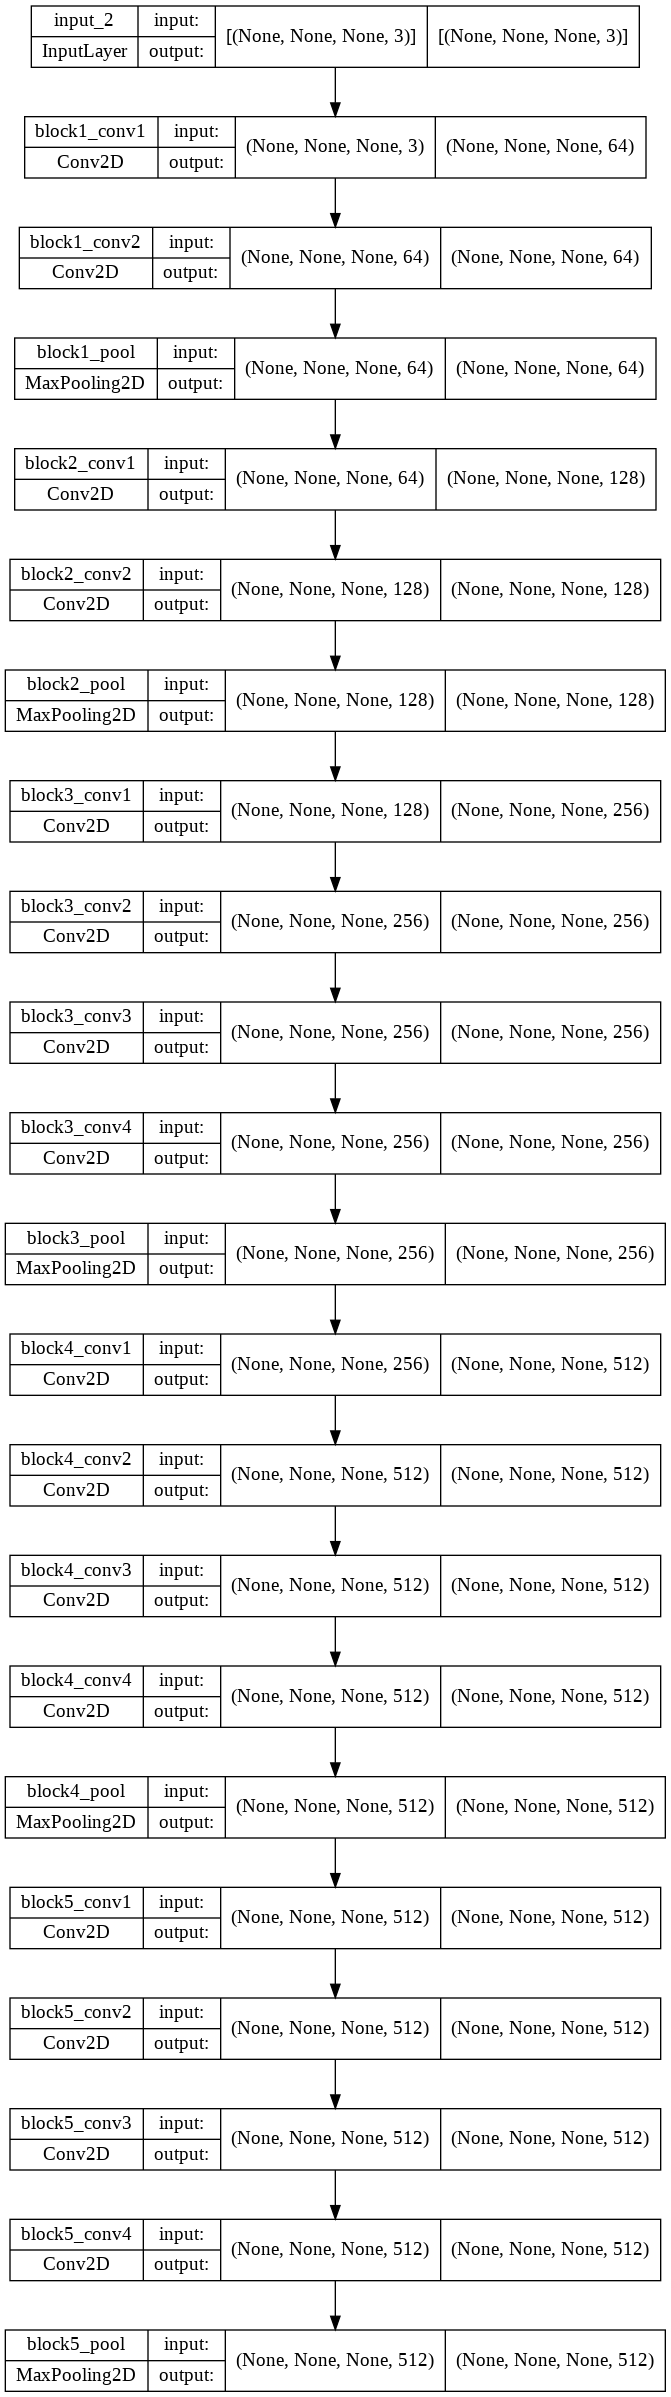

In [ ]:
keras.utils.plot_model(vgg, show_shapes=True)

# Calculating Gram Matrix

Next, we calculated the gram matrix. The content of an image is represented by the values of the intermediate feature maps. The style of an image can be described by the means and correlations across the different feature maps. A Gram matrix includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This can be implemented concisely using the tf.linalg.einsum function.


In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  26558.92
    mean:  892.8601

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  161283.1
    mean:  15884.046

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  779370.9
    mean:  15588.225

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  19431448.0
    mean:  166725.28

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  101875.914
    mean:  605.5961

Contents:
   block5_conv2
    shape:  (1, 29, 32, 512)
    min:  0.0
    max:  1011.7895
    mean:  8.2194195


We ran the above function on this model and it returned the gram matrix or style of the style_layers and content of the content_layers.

# Model Run

With this style and content extractor, we can now implement the style transfer algorithm. We can do this by calculating the mean square error for the image's output relative to each target, then take the weighted sum of these losses.


Setting the style and content target values


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

We defined a tf.Variable to contain the image to optimize. To make this quick, we initialized it with the content image.


In [ ]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Created an optimizer here. Adam with learning rate 0.02, beta as 0.99 and epsilon 0.1 works okay


In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, we used a weighted combination of the two losses to get the total loss.


In [ ]:
style_weight=1e-2
content_weight=1e4

One downside to this basic implementation is that it produces a lot of high frequency artifacts. We tried to decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
image = tf.Variable(content_image)

We ran the model in this block and this is the morphed spectrogram which we obtained.

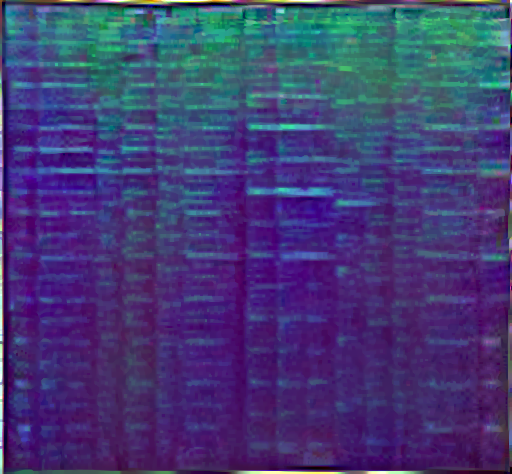

Train step: 1000
Total time: 279.5


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
im1 = tensor_to_image(image)
im1 = im1.save("/content/out.jpg")

# Cosine Simalrity Evaluation

In [ ]:
class TensorVector(object):

    def __init__(self, FileName=None):
        self.FileName = FileName

    def process(self):

        img = tf.io.read_file(self.FileName)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize_with_pad(img, 224, 224)
        img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...]
        features = embed(img)
        feature_set = np.squeeze(features)
        return list(feature_set)

In [ ]:
def convertBase64(FileName):
    """
    Return the Numpy array for an image 
    """
    with open(FileName, "rb") as f:
        data = f.read()
        
    res = base64.b64encode(data)
    
    base64data = res.decode("UTF-8")
    
    imgdata = base64.b64decode(base64data)
    
    image = Image.open(io.BytesIO(imgdata))
    
    return np.array(image)

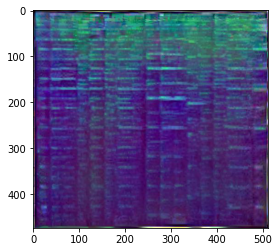

In [ ]:
plt.imshow(convertBase64("/content/out.jpg"))

In [ ]:
helper = TensorVector("/content/out.jpg")
vector = helper.process()

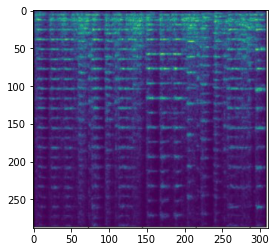

In [ ]:
plt.imshow(convertBase64("/content/content.jpg"))

In [ ]:
helper = TensorVector("/content/content.jpg")
vector2 = helper.process()

In [ ]:
def cosineSim(a1,a2):
    sum = 0
    suma1 = 0
    sumb1 = 0
    for i,j in zip(a1, a2):
        suma1 += i * i
        sumb1 += j*j
        sum += i*j
    cosine_sim = sum / ((sqrt(suma1))*(sqrt(sumb1)))
    return cosine_sim

In [ ]:
cosineSim(vector, vector2)

0.946789944822438

Next we calculated the cosine similarity between the morphed spectrogram and the content image. For this first we had to convert the image into an array and then apply the cosine similarity algorithm. The results do show a similarity score of 94% but that does not linearly translate into good audio style transfer. 